In [2]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
# get train & test csv files as a DataFrame
limit_rows   = 7000000

train_df = pd.read_csv("train_encoded.csv", nrows=limit_rows)
#train_df = pd.concat(reader)

unique_ids   = pd.Series(train_df["ncodpers"].unique())
limit_people = 1.2e4
unique_id    = unique_ids.sample(n=limit_people)
train_df     = train_df[train_df.ncodpers.isin(unique_id)]

In [4]:
train_df.head()

,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,...,fecha_dato_year,month_int,fecha_alta_month,fecha_alta_year,fecha_alta_day,fecha_alta_motnh_int,ult_fec_cli_1t_month,ult_fec_cli_1t_year,ult_fec_cli_1t_day,ult_fec_cli_1t_motnh_int
34,1050604,0,0,1,53,0,35,1,1,0,...,0,1,8,-3,10,8,0,5,0,60
80,1050511,0,0,1,23,0,35,1,1,1,...,0,1,8,-3,10,8,0,5,0,60
255,1050734,0,0,0,26,0,35,1,1,1,...,0,1,8,-3,10,8,0,5,0,60
387,1050137,0,0,0,23,0,35,1,1,1,...,0,1,8,-3,10,8,0,5,0,60
420,1050182,0,0,1,23,0,35,1,1,1,...,0,1,8,-3,10,8,0,5,0,60


In [55]:
train_df.columns

Index([u'index', u'ncodpers', u'ind_empleado', u'pais_residencia', u'sexo',
       u'age', u'ind_nuevo', u'antiguedad', u'indrel', u'indrel_1mes',
       u'tiprel_1mes', u'indresi', u'indext', u'conyuemp', u'canal_entrada',
       u'indfall', u'tipodom', u'cod_prov', u'ind_actividad_cliente', u'renta',
       u'segmento', u'ind_ahor_fin_ult1', u'ind_aval_fin_ult1',
       u'ind_cco_fin_ult1', u'ind_cder_fin_ult1', u'ind_cno_fin_ult1',
       u'ind_ctju_fin_ult1', u'ind_ctma_fin_ult1', u'ind_ctop_fin_ult1',
       u'ind_ctpp_fin_ult1', u'ind_deco_fin_ult1', u'ind_deme_fin_ult1',
       u'ind_dela_fin_ult1', u'ind_ecue_fin_ult1', u'ind_fond_fin_ult1',
       u'ind_hip_fin_ult1', u'ind_plan_fin_ult1', u'ind_pres_fin_ult1',
       u'ind_reca_fin_ult1', u'ind_tjcr_fin_ult1', u'ind_valo_fin_ult1',
       u'ind_viv_fin_ult1', u'ind_nomina_ult1', u'ind_nom_pens_ult1',
       u'ind_recibo_ult1', u'fecha_dato_month', u'fecha_dato_year',
       u'month_int', u'fecha_alta_month', u'fecha_alta_year

## Data Cleaning

### age

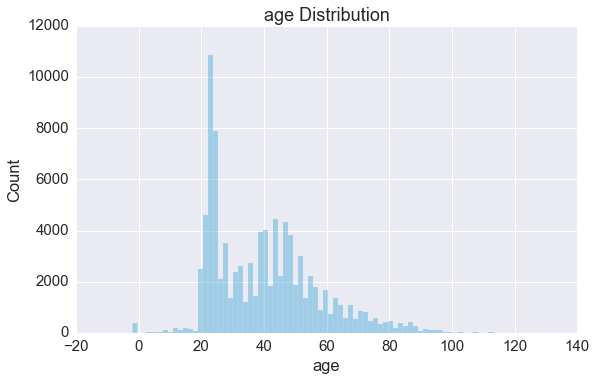

In [14]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style('darkgrid')
    sns.distplot(train_df["age"], bins=80, kde=False)
    sns.plt.title("age Distribution")
    plt.ylabel("Count")

In [15]:
train_df.age[train_df.age==-2].count()

380

In addition to NA, there are people with very small and very high ages. It's also interesting that the distribution is bimodal.   
There are a large number of university aged students, and then another peak around middle-age.  
Let's separate the distribution and move the outliers to the mean of the closest one.

In [16]:
train_df.ix[(train_df.age > -2)&(train_df.age < 18),"age"]  = train_df.ix[(train_df.age >= 18) & (train_df.age <= 30),"age"].mean()
train_df.ix[train_df.age > 100,"age"] = train_df.ix[(train_df.age >= 30) & (train_df.age <= 100),"age"].mean()
train_df.ix[train_df["age"]==-2,"age"] = train_df["age"].mean()
train_df["age"] = train_df["age"].astype(int)

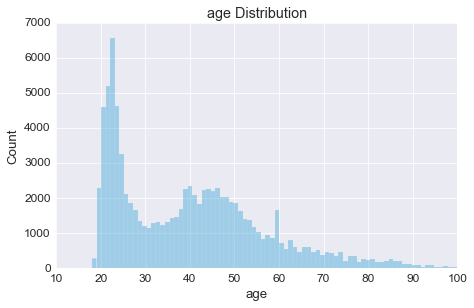

In [17]:
with sns.plotting_context("paper",font_scale=1.5):
    sns.set_style('darkgrid')
    sns.distplot(train_df["age"], bins=80, kde=False)
    sns.plt.title("age Distribution")
    plt.ylabel("Count")

### ind_nuevo
 which indicates whether a customer is new or not

In [28]:
train_df["ind_nuevo"].unique()

array([-1,  0,  1], dtype=int64)

In [31]:
train_df["ind_nuevo"].isin([-1]).sum()

380

Let's see if we can fill in missing values by looking how many months of history these customers have.

In [26]:
months_active = train_df.loc[train_df["ind_nuevo"].isin([-1]),:].groupby("ncodpers", sort=False).size()
months_active.max()

6

Looks like these are all new customers, so replace accordingly.

In [34]:
train_df.ix[train_df["ind_nuevo"].isin([-1]),"ind_nuevo"] = 1

### antiguedad
Customer seniority (in months)

In [37]:
train_df["antiguedad"].unique()

array([ -1, 162,  54, 115,  30, 116, 175, 104, 176, 128, 126, 114,  44,
        33,   6, 174,  16,  65,  89,  21,  66,  56, 150,   4,  79,  90,
        42, 163, 224,  29, 200,  68,  67, 210, 153,   9,   7,  18, 138,
       141, 164,  19, 152,  80, 186, 236,  78,  51,  49,  31,  45,  81,
       139, 177, 140,  32,  25,  92,  91, 119, 151, 110, 189, 157, 165,
       103,  11, 213,  99,  69, 132, 108, 169, 235, 102,  58,  26, 188,
        55,  62, 167,  10,  34, 234, 127,  82, 101, 161, 198, 246, 112,
       222,  20, 225,   8, 229,  72,  64,  43, 201,   5, 158, 121,  17,
       118,  12, 173, 109, 211, 160, 124,  52, 130, 212, 231, 187, 238,
       237, 159,  27, 155,  95, 113, 166, 129, 154,  93,  53, 168, 131,
       206, 120, 133, 107, 247,  75, 100,  94,  74,  50, 226, 230, 223,
       125, 209, 111, 214, 199, 105, 207, 227, 123, 232, 239, 156,  73,
        57, 208, 122, 182,  35,  41, 241,   0,  88, 249, 240,  59,  46,
       137,   3, 184,  28,   2, 248, 183,  96,  83, 181,   1,  6

In [42]:
train_df["antiguedad"].isin([-1]).sum()

380

same as ind_nuevo. Let's see if those are same customers.

In [43]:
train_df.ix[train_df["antiguedad"].isin([-1]),"ind_nuevo"].describe()

count    380.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: ind_nuevo, dtype: float64

same customers. Let's give them minimum seniority.

In [47]:
train_df.ix[train_df["antiguedad"].isin([-1]),"antiguedad"] = train_df["antiguedad"].min()

### fetcha_alta
Same entries don't have the date they joined the company.
- missing values are converted as below when data are squeezed  
DF['fecha_alta'] = DF['fecha_alta'].map(lambda x: '2020-00-00' if x == -1 else x)  
DF['fecha_alta_month'] = DF['fecha_alta'].map(lambda x: int(x[5:7])).astype(np.int8)  
DF['fecha_alta_year'] = DF['fecha_alta'].map(lambda x: int(x[0:4]) - 2015).astype(np.int8)  
DF['fecha_alta_day'] = DF['fecha_alta'].map(lambda x: int(x[8:10])).astype(np.int8)  
DF['fecha_alta_motnh_int'] = (DF['fecha_alta_month'] + 12 * DF['fecha_dato_year']).astype(np.int8)


In [64]:
train_df["fecha_alta_month"].isin([00]).sum()

380

filling missing values with medians respectively.

In [73]:
# fecha_alta_month
monthes = train_df.ix[:,"fecha_alta_month"].sort_values().reset_index()
median_month = int(np.median(monthes))
train_df.ix[train_df.fecha_alta_month.isin([-1]), "fecha_alta_month"] = monthes.ix[median_month, "fecha_alta_month"]
# fecha_alta_day
days = train_df.ix[:,"fecha_alta_day"].sort_values().reset_index()
median_day = int(np.median(days))
train_df.ix[train_df.fecha_alta_day.isin([-1]), "fecha_alta_day"] = days.ix[median_day, "fecha_alta_day"]
# fecha_alta_year
years = train_df.ix[:,"fecha_alta_year"].sort_values().reset_index()
median_year = int(np.median(years))
train_df.ix[train_df.fecha_alta_year.isin([-1]), "fecha_alta_year"] = years.ix[median_year, "fecha_alta_year"]
# fecha_alta_month_int
month_int = train_df.ix[:,"fecha_alta_motnh_int"].sort_values().reset_index()
median_month_int = int(np.median(month_int))
train_df.ix[train_df.fecha_alta_motnh_int.isin([-1]), "fecha_alta_motnh_int"] = month_int.ix[median_month_int, "fecha_alta_motnh_int"]

### indrel
1 (First/Primary), 99 (Primary customer during the month but not at the end of the month)

In [75]:
train_df["indrel"].unique()

array([-1,  1,  2], dtype=int64)

In [76]:
train_df["indrel"].isin([-1]).sum()

380

In [78]:
train_df["indrel"].value_counts()

 1    92838
-1      380
 2      155
Name: indrel, dtype: int64

filling with the most frequent values

In [79]:
train_df.ix[train_df.indrel.isin([-1]),"indrel"] = 1

### tipodom
Addres type. 1, primary address

In [81]:
train_df["tipodom"].value_counts()

 1    92993
-1      380
Name: tipodom, dtype: int64

doens't seem to be meaningful. so drop it.

In [83]:
train_df.drop(["tipodom"],axis=1,inplace=True)

### ind_actividad_cliente
Activity index (1, active customer; 0, inactive customer)  
should be conducted at the very fist step

In [99]:
train_df.ind_actividad_cliente.value_counts()

 0    47317
 1    45675
-1      379
Name: ind_actividad_cliente, dtype: int64

In [98]:
train_df.ind_actividad_cliente.isin([-1]).sum()

379

these entities should be excluded from the model.

In [105]:
train_df = train_df[train_df.ind_actividad_cliente != -1]

### cod_prov
Province code (customer's address)

In [110]:
train_df.cod_prov.isin([-1]).sum()

477

In [113]:
train_df.ix[train_df.cod_prov.isin([-1]),"cod_prov"] = train_df.cod_prov.median()

### renta
: gross income

In [6]:
train_df.renta[train_df.renta==-1].count()

17129

Here is a feature that is missing a lot of values. Filling missing values with a median might not be accurate.  
let's take a look at the median income by region and age

In [7]:
incomes = train_df.ix[train_df.renta!=-1,:].groupby("cod_prov").agg({"renta":{"MedianIncome":np.median}})
incomes.sort_values(by=("renta","MedianIncome"),inplace=True)
incomes.reset_index(inplace=True)
incomes.cod_prov = incomes.cod_prov.astype("category", categories=[i for i in train_df.cod_prov.unique()],ordered=False)
incomes.head()

,cod_prov,renta
,,MedianIncome
0,27,59396.039062
1,22,61284.435547
2,23,61401.871094
3,6,62178.238281
4,12,62354.488281


(40000, 180000)

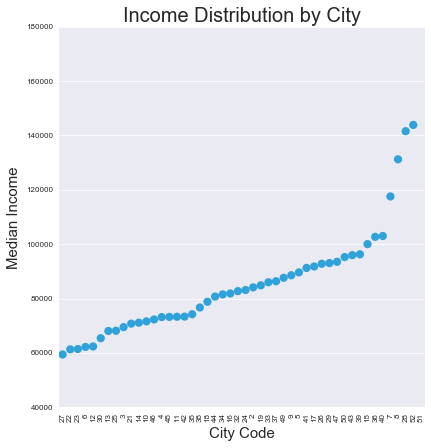

In [8]:
with sns.plotting_context("paper"):
    sns.set_style("darkgrid")
    sns.factorplot(x="cod_prov", y=("renta","MedianIncome"), data=incomes, size=6, linestyles="None", order=(i for i in incomes.cod_prov))

plt.title("Income Distribution by City",size=20)

plt.xticks(rotation=90)
plt.xlabel("City Code",size=15)

plt.ylabel("Median Income",size=15)
plt.ylim(40000,180000)

There's a lot of variation, so I think assigning missing incomes by providence is a good idea. First group the data by city, and reduce to get the median. This intermediate data frame is joined by the original city names to expand the aggregated median incomes, ordered so that there is a 1-to-1 mapping between the rows, and finally the missing values are replaced.

In [143]:
grouped = train_df.groupby("cod_prov").agg({"renta":lambda x: x.median()}).reset_index()
new_incomes = pd.merge(train_df,grouped,how="inner",on="cod_prov").ix[:, ["cod_prov","renta_y"]]
new_incomes = new_incomes.rename(columns={"renta_y":"renta"}).sort_values("renta").sort_values("cod_prov")
train_df.sort_values("cod_prov",inplace=True)
train_df = train_df.reset_index()
new_incomes = new_incomes.reset_index()

In [151]:
train_df.ix[train_df.renta.isin([-1]),"renta"] = new_incomes.ix[train_df.renta.isin([-1]),"renta"].reset_index()
train_df.ix[train_df.renta.isin([-1]),"renta"] = train_df.ix[train_df.renta.isin([not -1]),"renta"].median()
train_df.sort_values(by="fecha_alta_motnh_int",inplace=True)

### left features
There are many categorical features left to be cleaned. First, let's take a look at them.

In [115]:
train_df.isin([-1]).any()

index                       False
ncodpers                    False
ind_empleado                False
pais_residencia             False
sexo                        False
age                         False
ind_nuevo                   False
antiguedad                  False
indrel                      False
indrel_1mes                  True
tiprel_1mes                  True
indresi                     False
indext                      False
conyuemp                     True
canal_entrada               False
indfall                     False
cod_prov                    False
ind_actividad_cliente       False
renta                        True
segmento                     True
ind_ahor_fin_ult1           False
ind_aval_fin_ult1           False
ind_cco_fin_ult1            False
ind_cder_fin_ult1           False
ind_cno_fin_ult1            False
ind_ctju_fin_ult1           False
ind_ctma_fin_ult1           False
ind_ctop_fin_ult1           False
ind_ctpp_fin_ult1           False
ind_deco_fin_u

In [130]:
missing_features = ["indrel_1mes", "tiprel_1mes", "conyuemp", "segmento", "ind_nomina_ult1", "ind_nom_pens_ult1"]
for col in missing_features:
    print("Unique values for {0}:\n{1}\n".format(col,train_df[col].unique()))

Unique values for indrel_1mes:
[ 1  3  2  4 -2]

Unique values for tiprel_1mes:
[1 0 2 4]



KeyError: 'conyuemp'

conyuemp has one type of values to drop it.

In [123]:
train_df.drop(["conyuemp"], axis=1, inplace=True)

### indrel_1mes

In [124]:
train_df["indrel_1mes"].value_counts()

 1    91973
-1      989
 3       15
 2        8
-2        5
 4        2
Name: indrel_1mes, dtype: int64

filling missing values with the most frequent value, which is 1.

In [125]:
train_df.ix[train_df.indrel_1mes.isin([-1]), "indrel_1mes"] = 1

### tiprel_1mes
Customer relation type at the beginning of the month, 0 (active), 1 (inactive), 2 (former customer), 4 (Potential)

In [126]:
train_df["tiprel_1mes"].value_counts()

 1    46995
 0    44986
-1      989
 2       17
 4        5
Name: tiprel_1mes, dtype: int64

In [128]:
train_df.ix[train_df.tiprel_1mes.isin([-1]), "tiprel_1mes"] = 0

### segmento
segmentation: 01 - VIP, 02 - Individuals 03 - college graduated

In [129]:
train_df["segmento"].value_counts()

 2    54719
 3    32862
 1     4257
-1     1154
Name: segmento, dtype: int64

In [134]:
train_df.ix[train_df.segmento.isin([-1]), "segmento"] = 2

### ind_nomina_ult1, ind_nom_pens_ult1

In [138]:
train_df["ind_nomina_ult1"].value_counts()

 0    87139
 1     5850
-1        3
Name: ind_nomina_ult1, dtype: int64

In [139]:
train_df["ind_nom_pens_ult1"].value_counts()

 0    86627
 1     6362
-1        3
Name: ind_nom_pens_ult1, dtype: int64

The numer of missing values is very small. just replace them with the most common value.

In [146]:
train_df.loc[train_df.ind_nomina_ult1.isin([-1]), "ind_nomina_ult1"] = 0
train_df.loc[train_df.ind_nom_pens_ult1.isin([-1]), "ind_nom_pens_ult1"] = 0

In [154]:
train_df.isin([-1]).any().sum()

0